# Installation Setup

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [63]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import torch
import gym

import StockPortfolioEnv
import utils
import TD3_BC

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [64]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [10]:
train_data = pd.read_csv('data/train_data.csv', index_col=0)
trade_data = pd.read_csv('data/trade_data.csv', index_col=0)

In [11]:
train = train_data
trade = trade_data

stock_dimension = len(train.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


In [12]:
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weight_type="RETAIL")

begin_total_asset:1000000
end_total_asset:4904419.075973194
Sharpe:  0.6729768484476764


# Modelling
> Use a two-stage scheme (supervised learning & reinforcement learning), in analogy to AlphaGo and ChatGPT. The first stage learns from human trader logs, while the second stage leverages reinforcement learning to achieve super-human performance.

In [84]:
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["moribvol"])
true_portfolio_train = e_train_gym.asset_memory
true_actions_train = e_train_gym.actions_memory

begin_total_asset:1000000
end_total_asset:4904419.075973194
Sharpe:  0.6729768484476764


In [184]:
def softmax(x):
    """Compute softmax values for each row of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

def plot_portfolio(y1, y2):
    plt.plot(y1, label='reg')
    plt.plot(y2, label='Ground Truth')

    plt.legend()
    plt.ylabel('Portfolio Value')
    plt.xlabel('timesteps')
    plt.show()
    
def plot_mse(y1, y2):
    plt.plot(np.mean((y1 - y2.values.reshape(-1, stock_dimension)), axis=1)**2)
    plt.ylabel('MSE')
    plt.xlabel('timesteps')
    plt.show()

## Regression

In [129]:
X = train_data[tech_indicator_list]
Y = train_data["moribvol"]

olsres = sm.OLS(Y.values.reshape(-1),
                sm.add_constant(X.values.reshape(-1, feature_dimension))).fit()

reg_fit = olsres.predict(sm.add_constant(X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_fit = softmax(y_fit)

begin_total_asset:1000000
end_total_asset:3841898.2757355147
Sharpe:  0.6109941521683996


Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'timesteps')

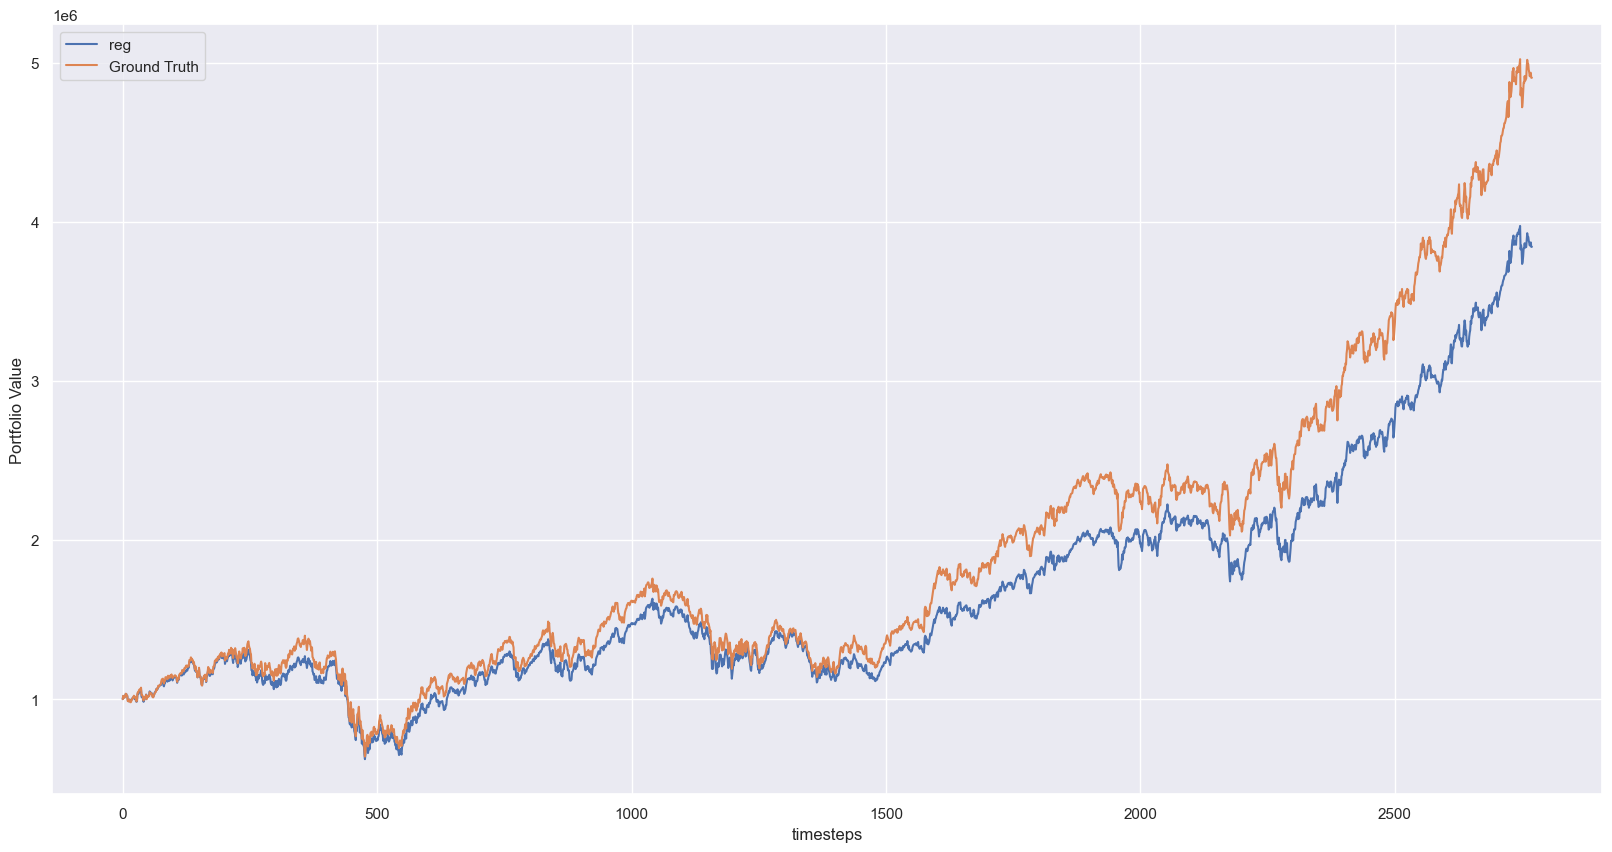

In [130]:
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=reg_fit)
reg_portfolio_train = e_train_gym.asset_memory

plot_portfolio(reg_portfolio_train, true_portfolio_train)

Text(0, 0.5, 'MSE')

Text(0.5, 0, 'timesteps')

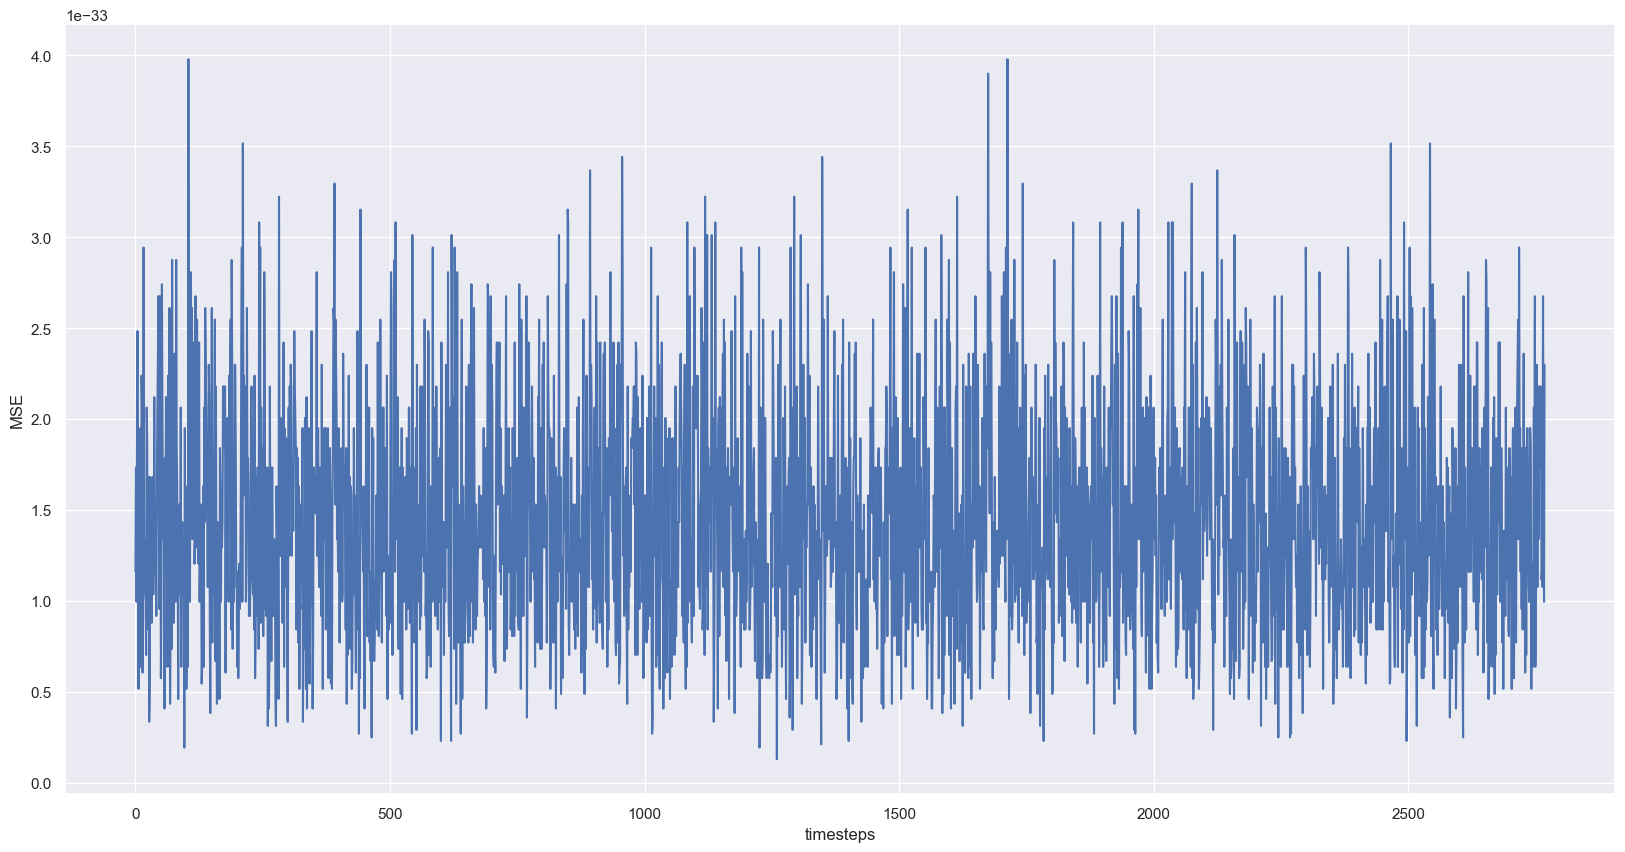

In [119]:
plot_mse(reg_fit, Y)

In [123]:
olsres = sm.OLS(pd.Series(true_portfolio_train).pct_change(), 
                (sm.add_constant(pd.Series(reg_portfolio_train)).pct_change()), missing="drop").fit()

print(olsres.summary())

# olsres = sm.OLS(np.asarray(true_actions_train).reshape(-1), 
#                 np.asarray(reg_fit[:-1]).reshape(-1)).fit()

# print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                          1.096e+05
Date:                Sun, 12 Mar 2023   Prob (F-statistic):                        0.00
Time:                        19:27:08   Log-Likelihood:                          49310.
No. Observations:               30448   AIC:                                 -9.862e+04
Df Residuals:                   30447   BIC:                                 -9.861e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Tree

In [131]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X, Y)

clf_fit = clf.predict((X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_fit = softmax(clf_fit)

RandomForestRegressor(max_depth=2, random_state=0)

begin_total_asset:1000000
end_total_asset:3843266.9780635866
Sharpe:  0.6109682673652438


Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'timesteps')

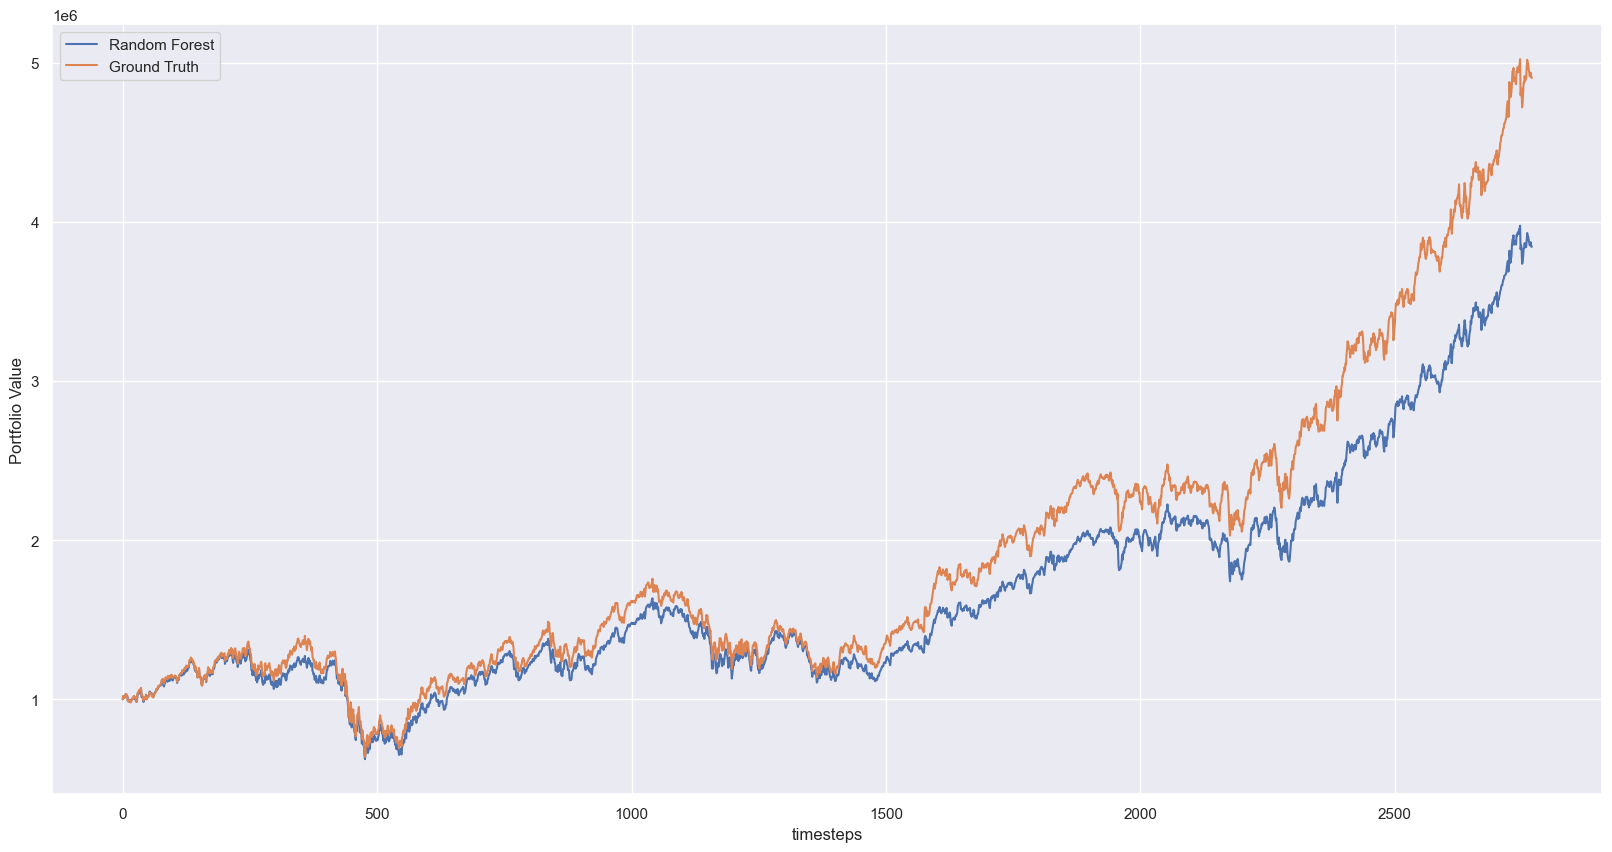

In [132]:
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=clf_fit)
clf_portfolio_train = e_train_gym.asset_memory

plot_portfolio(clf_portfolio_train, true_portfolio_train)

Text(0, 0.5, 'MSE')

Text(0.5, 0, 'timesteps')

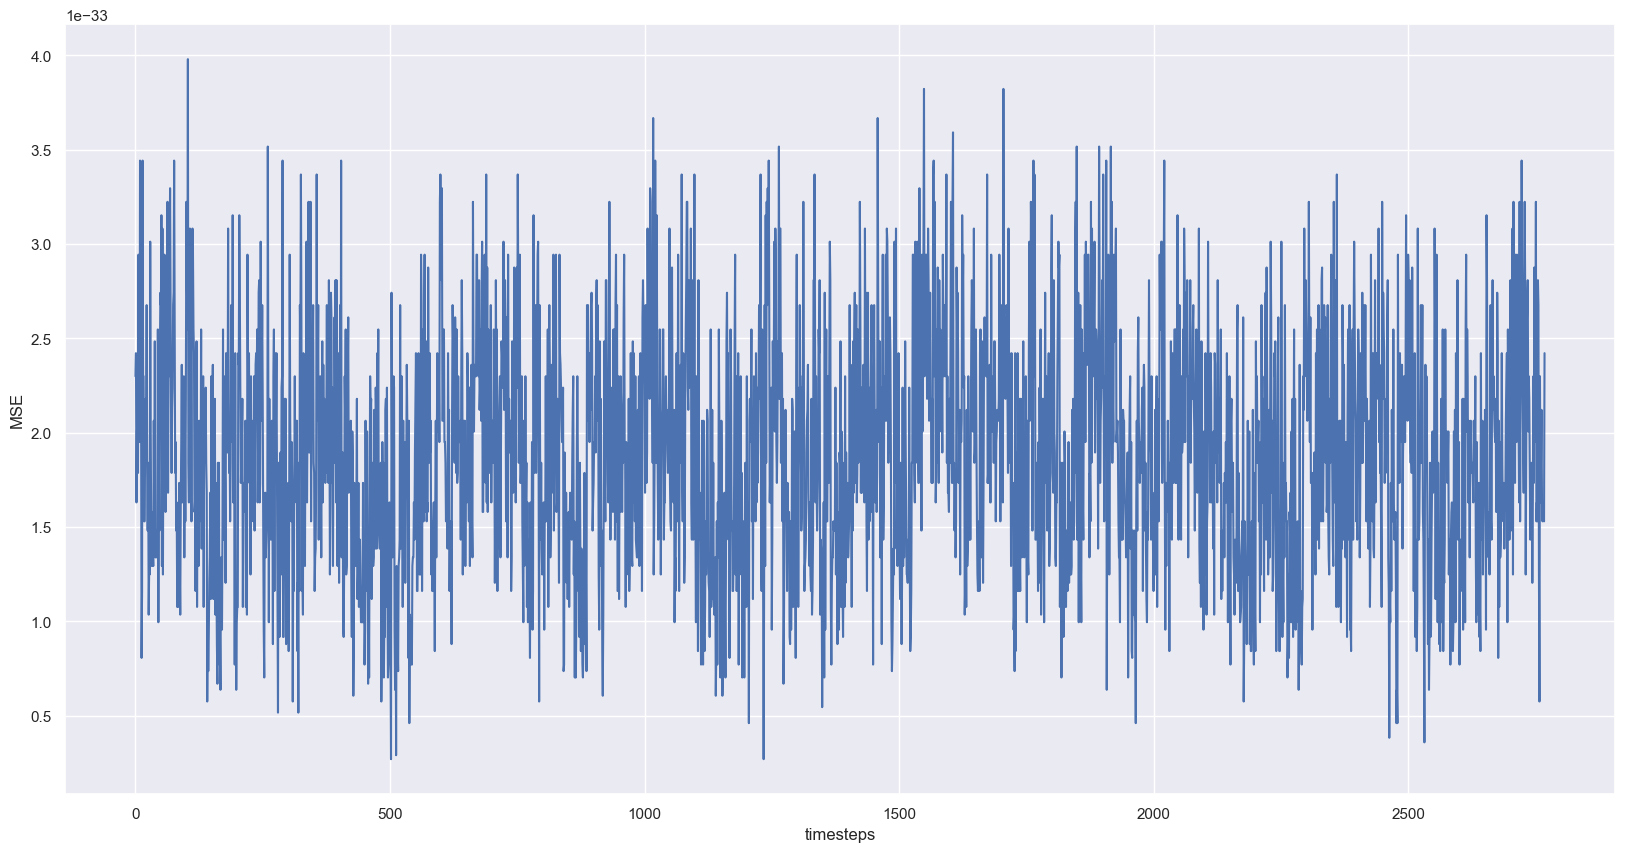

In [128]:
plot_mse(clf_fit, Y)

In [135]:
olsres = sm.OLS(pd.Series(true_portfolio_train).pct_change(), 
                (sm.add_constant(pd.Series(reg_portfolio_train)).pct_change()), missing="drop").fit()

print(olsres.summary())

# olsres = sm.OLS(np.asarray(true_actions_train).reshape(-1), 
#                 np.asarray(clf_fit[:-1]).reshape(-1)).fit()

# print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          8.558e+04
Date:                Sun, 12 Mar 2023   Prob (F-statistic):                        0.00
Time:                        19:48:18   Log-Likelihood:                          12158.
No. Observations:                2769   AIC:                                 -2.431e+04
Df Residuals:                    2768   BIC:                                 -2.431e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## LSTM

In [188]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
      

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return F.softmax(out)


torch.manual_seed(42)

# Prepare dataset
X = X.astype(np.float32) 
Y = Y.astype(np.float32) 

dataset = Dataset(X.values.reshape(-1, 44), Y.values.reshape(-1, 11))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
lstm = LSTMModel(input_size=44, hidden_size=128, num_layers=1, output_size=11)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
num_epochs = 5000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/5000], Loss: 0.0021
Epoch [20/5000], Loss: 0.0020
Epoch [30/5000], Loss: 0.0019
Epoch [40/5000], Loss: 0.0019
Epoch [50/5000], Loss: 0.0018
Epoch [60/5000], Loss: 0.0017
Epoch [70/5000], Loss: 0.0017
Epoch [80/5000], Loss: 0.0016
Epoch [90/5000], Loss: 0.0016
Epoch [100/5000], Loss: 0.0016
Epoch [110/5000], Loss: 0.0016
Epoch [120/5000], Loss: 0.0015
Epoch [130/5000], Loss: 0.0015
Epoch [140/5000], Loss: 0.0014
Epoch [150/5000], Loss: 0.0014
Epoch [160/5000], Loss: 0.0014
Epoch [170/5000], Loss: 0.0014
Epoch [180/5000], Loss: 0.0013
Epoch [190/5000], Loss: 0.0014
Epoch [200/5000], Loss: 0.0014
Epoch [210/5000], Loss: 0.0013
Epoch [220/5000], Loss: 0.0013
Epoch [230/5000], Loss: 0.0012
Epoch [240/5000], Loss: 0.0012
Epoch [250/5000], Loss: 0.0012
Epoch [260/5000], Loss: 0.0012
Epoch [270/5000], Loss: 0.0012
Epoch [280/5000], Loss: 0.0011
Epoch [290/5000], Loss: 0.0012
Epoch [300/5000], Loss: 0.0011
Epoch [310/5000], Loss: 0.0011
Epoch [320/5000], Loss: 0.0011
Epoch [330/5000],

Epoch [2610/5000], Loss: 0.0003
Epoch [2620/5000], Loss: 0.0003
Epoch [2630/5000], Loss: 0.0003
Epoch [2640/5000], Loss: 0.0003
Epoch [2650/5000], Loss: 0.0003
Epoch [2660/5000], Loss: 0.0003
Epoch [2670/5000], Loss: 0.0003
Epoch [2680/5000], Loss: 0.0003
Epoch [2690/5000], Loss: 0.0003
Epoch [2700/5000], Loss: 0.0003
Epoch [2710/5000], Loss: 0.0003
Epoch [2720/5000], Loss: 0.0003
Epoch [2730/5000], Loss: 0.0003
Epoch [2740/5000], Loss: 0.0004
Epoch [2750/5000], Loss: 0.0003
Epoch [2760/5000], Loss: 0.0003
Epoch [2770/5000], Loss: 0.0003
Epoch [2780/5000], Loss: 0.0003
Epoch [2790/5000], Loss: 0.0003
Epoch [2800/5000], Loss: 0.0003
Epoch [2810/5000], Loss: 0.0003
Epoch [2820/5000], Loss: 0.0003
Epoch [2830/5000], Loss: 0.0003
Epoch [2840/5000], Loss: 0.0003
Epoch [2850/5000], Loss: 0.0003
Epoch [2860/5000], Loss: 0.0003
Epoch [2870/5000], Loss: 0.0003
Epoch [2880/5000], Loss: 0.0003
Epoch [2890/5000], Loss: 0.0003
Epoch [2900/5000], Loss: 0.0003
Epoch [2910/5000], Loss: 0.0003
Epoch [2

begin_total_asset:1000000
end_total_asset:4709181.10148131
Sharpe:  0.6590339018434035


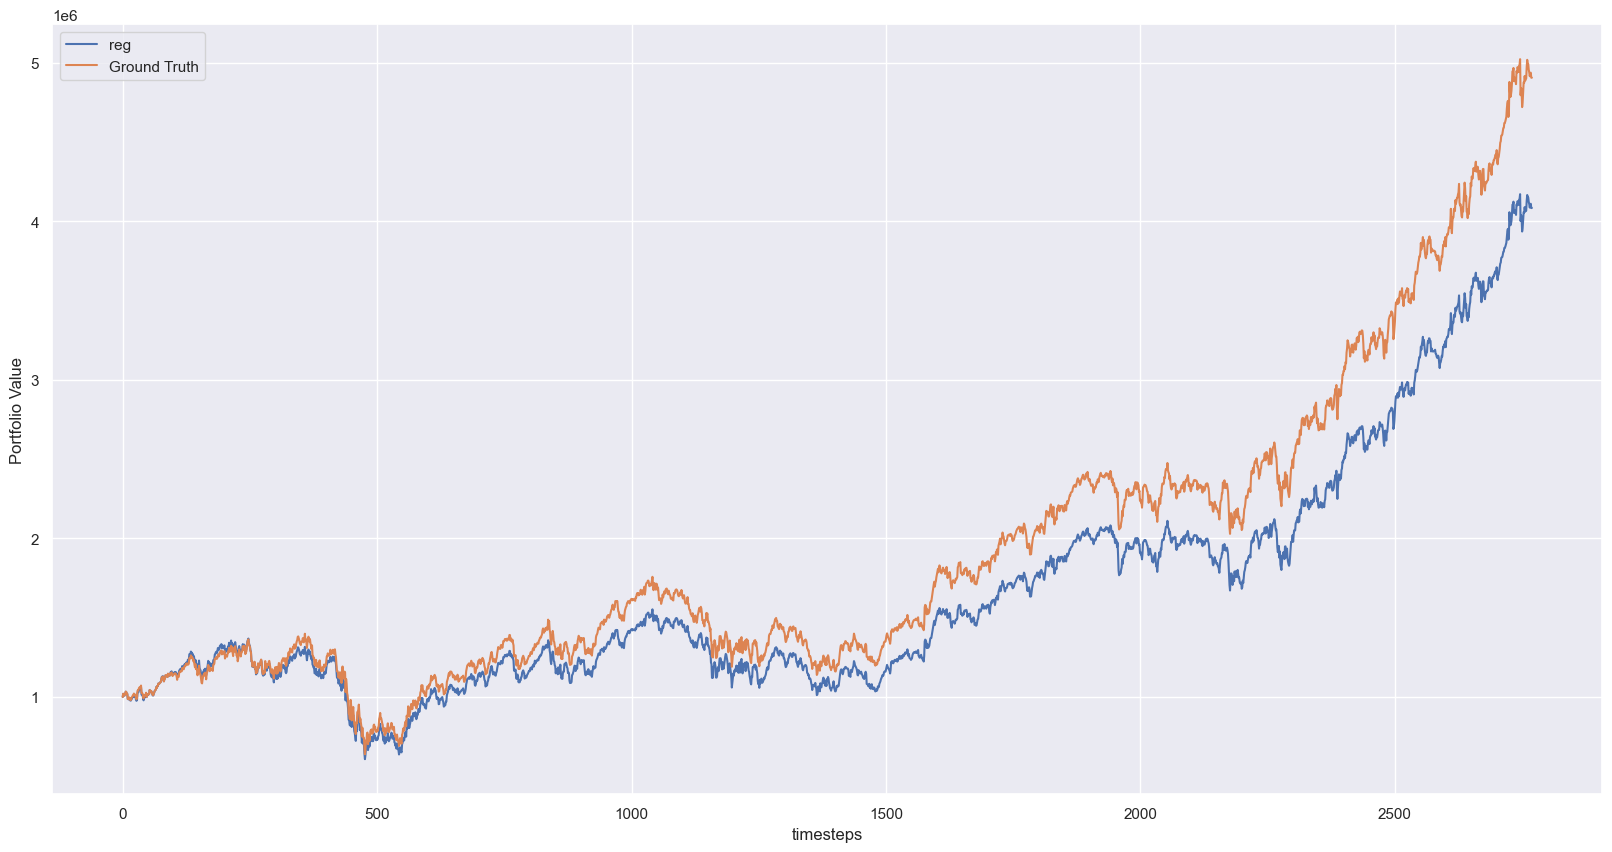

In [190]:
lstm_fit = lstm(dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=lstm_fit)
lstm_portfolio_train = e_train_gym.asset_memory

plot_portfolio(reg_portfolio_train, true_portfolio_train)

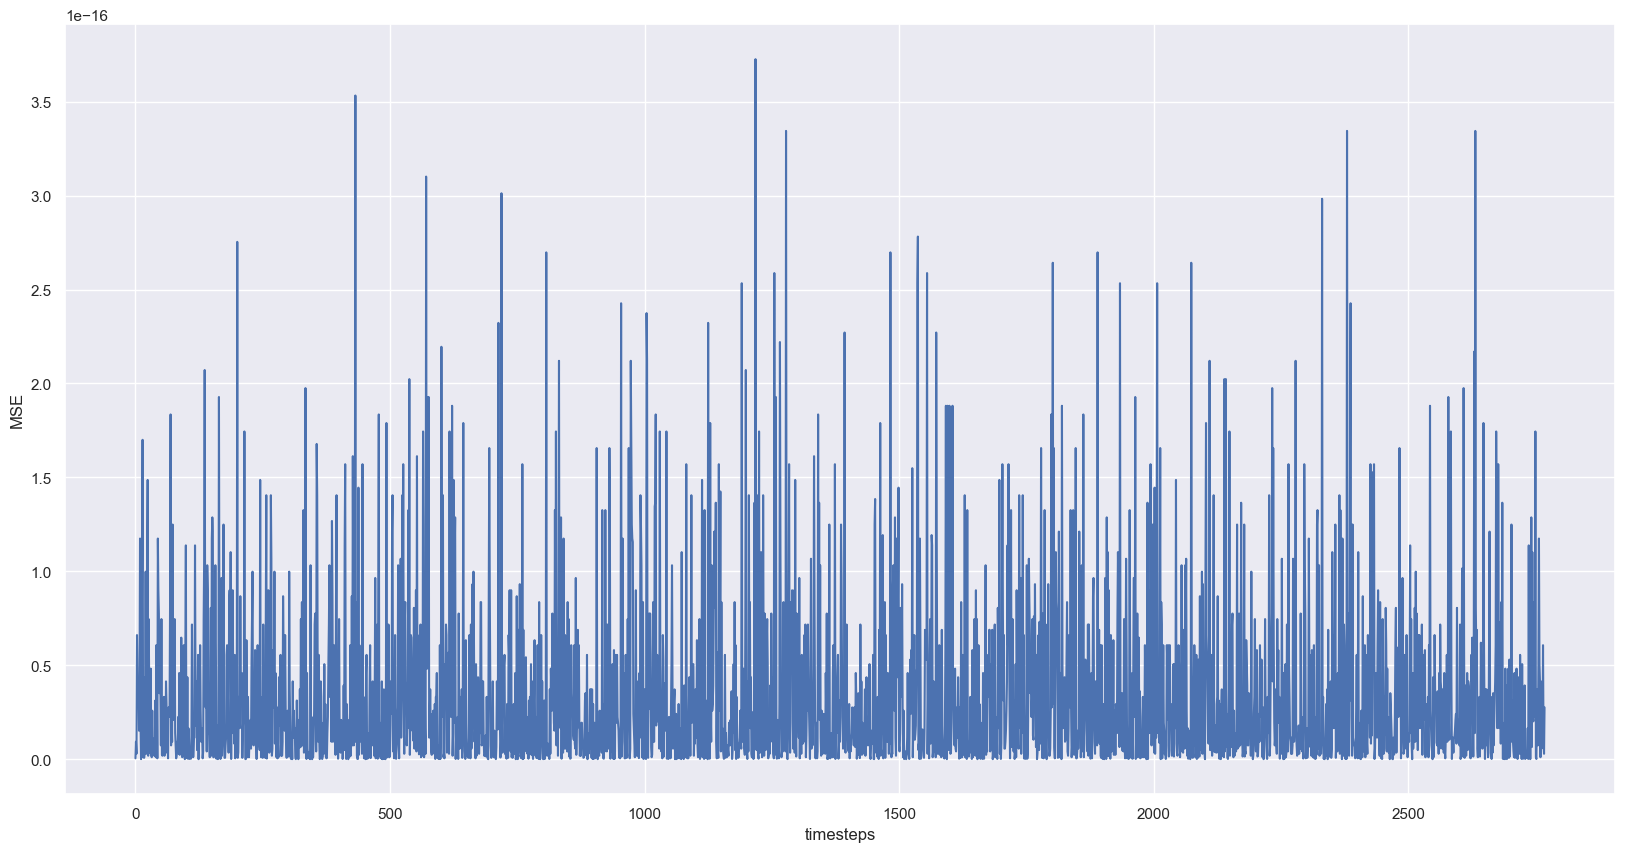

In [191]:
plot_mse(lstm_fit, Y)

In [192]:
olsres = sm.OLS(pd.Series(true_portfolio_train).pct_change(), 
                (sm.add_constant(pd.Series(lstm_portfolio_train)).pct_change()), missing="drop").fit()

print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          8.709e+05
Date:                Tue, 14 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:29:15   Log-Likelihood:                          15331.
No. Observations:                2769   AIC:                                 -3.066e+04
Df Residuals:                    2768   BIC:                                 -3.065e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## First stage - Supervised Learning
> Fundemental models: regression, tree, lstm and ann 

> Placebo tests: features (subset or random variables that has the mean and std), imitate mean-var, XLF

In [ ]:
# Runs policy for X episodes and returns D4RL score: A fixed seed is used for the eval environment

def eval_policy(policy, eval_env, seed, mean, std, seed_offset=100, eval_episodes=1):
    # eval_env = gym.make(env_name)
    eval_env.reset()
    eval_env.seed(seed + seed_offset)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            state = (np.array(state).reshape(1,-1) - mean)/std
            action = policy.select_action(state)
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    # 	d4rl_score = eval_env.get_normalized_score(avg_reward) * 100

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    # 	print(f"Evaluation over {eval_episodes} episodes")
    print("---------------------------------------")
    return avg_reward

In [ ]:
# Experiment
policy = "TD3+BC" # Policy name
env = e_train_gym # OpenAI gym environment name
seed = 0 # Sets Gym, PyTorch and Numpy seeds
eval_freq = 1e3 # How often (time steps) we evaluate
max_timesteps = 1e5 # Max time steps to run environment
save_model = True # Save model and optimizer parameters
load_model = "" # Model load file name, "" doesn't load, "default" uses file_name
file_name = f"BC_{seed}"

# TD3
expl_noise = 0.1 # Std of Gaussian exploration noise
batch_size = 256 # Batch size for both actor and critic
discount = 0.99 # Discount factor
tau = 0.005 # Target network update rate
policy_noise = 0.2 # Noise added to target policy during critic update
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 1 # Frequency of delayed policy updates

# TD3 + BC
alpha = 0
normalize = True

In [ ]:
print("---------------------------------------")
print(f"Policy: {policy}, Env: {env}, Seed: {seed}")
print("---------------------------------------")

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": discount,
    "tau": tau,
    # TD3
    "policy_noise": policy_noise * max_action,
    "noise_clip": noise_clip * max_action,
    "policy_freq": policy_freq,
    # TD3 + BC
    "alpha": alpha
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)

# if load_model != "":
#     policy_file = file_name if load_model == "default" else load_model
#     policy.load(f"./models/{policy_file}")

replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(retail_train)

# flatten
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

if normalize:
    mean,std = replay_buffer.normalize_states() 
else:
    mean,std = 0,1

In [ ]:
days = len(env.actions_memory)
evaluations = []
portfolio_values = []
fitted = []

for t in range(int(max_timesteps)):
    policy.train(replay_buffer, batch_size)
    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        print(f"Time steps: {t+1}")
        evaluations.append(eval_policy(policy, env, seed, mean, std))
        portfolio_values.append(env.portfolio_value)
        fitted.append(np.mean((np.array(env.actions_memory) - np.array(train_y.loc[:days-1]["moribvol"]).reshape(-1, 11)) ** 2))
        
        # np.save(f"./results/{file_name}", evaluations)
        # if save_model: policy.save(f"./models/{file_name}")

# Mertrics

In [ ]:
if file_name == f"BC_{seed}":
    evaluations_0 = evaluations.copy()
    portfolio_values_0 = portfolio_values.copy()
    fitted_0 = fitted.copy()
elif file_name == f"TD3+BC_{seed}":
    evaluations_1 = evaluations.copy()
    portfolio_values_1 = portfolio_values.copy()
    fitted_1 = fitted.copy()

evaluations_2 = sum(retail_train["rewards"])
portfolio_values_2 = sum(retail_train["rewards"]) + 1000000 # 1000000 being initial capital

## Cumulative rewards

In [ ]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_0, label='SL')
# plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_1, label='SL+RL')
plt.axhline(y=evaluations_2, label='Ground Truth', color = 'r')

plt.legend()
plt.title('Training')
plt.ylabel('cumulative rewards (PnL)')
plt.xlabel('timesteps')
plt.show()

### Portfolio values

In [ ]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), portfolio_values_0, label='SL')
# plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_1, label='SL+RL')
plt.axhline(y=portfolio_values_2, label='Ground Truth', color = 'r')

plt.legend()
plt.title('Training')
plt.ylabel('Portfolio Value')
plt.xlabel('timesteps')
plt.show()

## MSE

In [ ]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), fitted_0, label='SL')
# plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_1, label='SL+RL')

plt.legend()
plt.title('Training')
plt.ylabel('MSE')
plt.xlabel('timesteps')
plt.show()

## Backtest

In [ ]:
from copy import deepcopy
trade_dataset = sample_from_env(i=0, env=e_trade_gym, is_train=False)
true_asset_memory_trade = deepcopy(e_trade_gym.asset_memory)
true_action_memory_trade = deepcopy(e_trade_gym.actions_memory)

In [ ]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(trade_dataset)
seed = 0

# flatten
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

if normalize:
    mean,std = replay_buffer.normalize_states() 
else:
    mean,std = 0,1
    
eval_policy(policy, e_trade_gym, seed, mean, std)

In [ ]:
# historical portfolio values 
plt.plot(trade_y['date'].unique(), e_trade_gym.asset_memory[:-1], label='Predicted')
plt.plot(trade_y['date'].unique(), true_asset_memory_trade[:-1], label='Ground Truth')
plt.xlabel('Date')
plt.ylabel('Portfolio values ')
plt.legend()
plt.show()

In [ ]:
# how weights change over time (simulated vs. real)
# Hard to observe though!

selected_tech_tic = ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]
selected_tech_tic.sort()

true_action_memory_trade = np.asarray(true_action_memory_trade)

fig, axs = plt.subplots(nrows=11, ncols=1, figsize=(8, 20), sharex=True)

# Plot each weight column against the date column
for i in range(11):
    axs[i].plot(trade_y['date'].unique()[:-1], true_action_memory_trade[:, i])
    axs[i].set_ylabel("Fitted " + selected_tech_tic[i])
    axs[i].grid(True)

axs[-1].set_xlabel('Date')
plt.suptitle('Weight Changes Over Time', fontsize=16)
plt.show()

In [ ]:
# Measures (OLS, cosine similarity, or correlation) of asset allocations

# Compute cosine similarity
from scipy.spatial.distance import cosine

cos_sims = [1 - cosine(true_action_memory_trade[i], e_trade_gym.actions_memory[i]) for i in range(len(true_action_memory_trade))]
plt.plot(trade_y['date'].unique()[:-1], cos_sims)
plt.xlabel('Date')
plt.title('Cosine Similarity')
plt.show()


In [ ]:
# plt.plot(np.std(true_action_memory_trade, axis=1))
np.std(true_action_memory_trade, axis=1)

In [ ]:
# plt.plot(np.std(e_trade_gym.actions_memory, axis=1))
np.std(e_trade_gym.actions_memory, axis=1)

In [ ]:
# correlation
corrcoef = [np.corrcoef(true_action_memory_trade[i], e_trade_gym.actions_memory[i])[0, 1]
                        for i in range(len(true_action_memory_trade))]
plt.plot(trade_y['date'].unique()[:-1], corrcoef)
plt.xlabel('Date')
plt.title('Correlation')
plt.show()

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error

mse = [mean_squared_error(true_action_memory_trade[i], e_trade_gym.actions_memory[i])
       for i in range(len(true_action_memory_trade))]
plt.plot(trade_y['date'].unique()[:-1], mse)
plt.xlabel('Date')
plt.title('MSE')
plt.show()

In [ ]:
#fit linear regression model

# olsres = sm.OLS(np.asarray(true_action_memory_trade).reshape(-1), 
#                 np.asarray(e_trade_gym.actions_memory).reshape(-1)).fit()

# print(olsres.summary())

olsres = sm.OLS(pd.Series(true_asset_memory_trade[:-1]).pct_change(), 
                sm.add_constant(pd.Series(e_trade_gym.asset_memory[:-1]).pct_change()), missing="drop").fit()

# plt.plot(trade_y['date'].unique(), e_trade_gym.asset_memory[:-1], label='Predicted')
# plt.plot(trade_y['date'].unique(), true_asset_memory_trade[:-1], label='Ground Truth')

#view model summary
print(olsres.summary())

## Exploration to finetune (TD3+BC)

In [ ]:
# # Experiment
# policy = "TD3+BC" # Policy name
# env = e_train_gym # OpenAI gym environment name
# seed = 0 # Sets Gym, PyTorch and Numpy seeds
# eval_freq = 1e3 # How often (time steps) we evaluate
# max_timesteps = 1e5 # Max time steps to run environment
# save_model = True # Save model and optimizer parameters
# load_model = "" # Model load file name, "" doesn't load, "default" uses file_name
# file_name = f"TD3_{seed}"

# # TD3
# expl_noise = 0.1 # Std of Gaussian exploration noise
# batch_size = 256 # Batch size for both actor and critic
# discount = 0.99 # Discount factor
# tau = 0.005 # Target network update rate
# policy_noise = 0.2 # Noise added to target policy during critic update
# noise_clip = 0.5 # Range to clip target policy noise
# policy_freq = 2 # Frequency of delayed policy updates

# # TD3 + BC
# alpha = 0
# beta = 1
# normalize = True

In [ ]:
# # Set seeds
# env.seed(seed)
# env.action_space.seed(seed)
# torch.manual_seed(seed)
# np.random.seed(seed)

# state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
# action_dim = env.action_space.shape[0] 
# max_action = float(env.action_space.high[0])

In [ ]:
# print("---------------------------------------")
# print(f"Policy: {policy}, Env: {env}, Seed: {seed}")
# print("---------------------------------------")

# kwargs = {
#     "state_dim": state_dim,
#     "action_dim": action_dim,
#     "max_action": max_action,
#     "discount": discount,
#     "tau": tau,
#     # TD3
#     "policy_noise": policy_noise * max_action,
#     "noise_clip": noise_clip * max_action,
#     "policy_freq": policy_freq,
#     # TD3 + BC
#     "alpha": alpha,
#     "beta": beta
# }

# # Initialize policy
# policy = TD3_BC.TD3_BC(**kwargs)
# # policy.load(f"./models/BC_0")

In [ ]:
# replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
# replay_buffer.convert_D4RL(retail_train)

# # flatten
# replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
# replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

# if normalize:
#     mean,std = replay_buffer.normalize_states() 
# else:
#     mean,std = 0,1

In [ ]:
# evaluations = []
# portfolio_values = []
# for t in range(int(max_timesteps)):
#     policy.train(replay_buffer, batch_size)
#     # Evaluate episode
#     if (t + 1) % eval_freq == 0:
#         print(f"Time steps: {t+1}")
#         evaluations.append(eval_policy(policy, env, seed, mean, std))
#         portfolio_values.append(env.portfolio_value)
